RAG를 활용한 대화형 챗봇


In [3]:
# !pip install streamlit-chat
# !pip install streamlit
# !pip install langchain
# !pip install faiss-cpu
!pip install -U langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.8 MB/s eta 0:00:00


In [4]:
import streamlit as st
from streamlit_chat import message
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.vectorstores import FAISS
import tempfile
from langchain.document_loaders import PyPDFLoader

import os
os.environ["OPENAI_API_KEY"] = ""

uploaded_file = st.sidebar.file_uploader("upload", type="pdf")

2024-07-19 09:10:26.307 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


In [5]:
if uploaded_file :
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        tmp_file.write(uploaded_file.getvalue())
        tmp_file_path = tmp_file.name

    loader = PyPDFLoader(tmp_file_path)
    data = loader.load()

    embeddings = OpenAIEmbeddings()
    vectors = FAISS.from_documents(data, embeddings)

    chain = ConversationalRetrievalChain.from_llm(llm = ChatOpenAI(temperature=0.0,model_name='gpt-4'), retriever=vectors.as_retriever())

    def conversational_chat(query):  #문맥 유지를 위해 과거 대화 저장 이력에 대한 처리
        result = chain({"question": query, "chat_history": st.session_state['history']})
        st.session_state['history'].append((query, result["answer"]))
        return result["answer"]

    if 'history' not in st.session_state:
        st.session_state['history'] = []

    if 'generated' not in st.session_state:
        st.session_state['generated'] = ["안녕하세요! " + uploaded_file.name + "에 관해 질문주세요."]

    if 'past' not in st.session_state:
        st.session_state['past'] = ["안녕하세요!"]

    #챗봇 이력에 대한 컨테이너
    response_container = st.container()
    #사용자가 입력한 문장에 대한 컨테이너
    container = st.container()

    with container: #대화 내용 저장(기억)
        with st.form(key='Conv_Question', clear_on_submit=True):
            user_input = st.text_input("Query:", placeholder="PDF파일에 대해 얘기해볼까요? (:", key='input')
            submit_button = st.form_submit_button(label='Send')

        if submit_button and user_input:
            output = conversational_chat(user_input)

            st.session_state['past'].append(user_input)
            st.session_state['generated'].append(output)

    if st.session_state['generated']:
        with response_container:
            for i in range(len(st.session_state['generated'])):
                message(st.session_state["past"][i], is_user=True, key=str(i) + '_user', avatar_style = "fun-emoji", seed = "Nala")
                message(st.session_state["generated"][i], key=str(i), avatar_style = "bottts", seed = "Fluffy")


## Result
#### UI에 넣고자하는 PDF을 Drag&Drop으로 staging
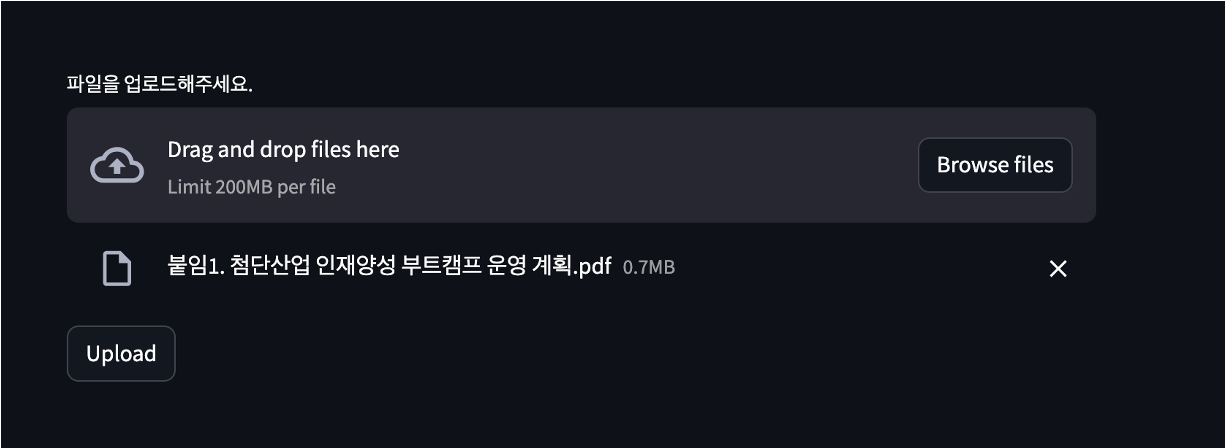

### Uploading PDF
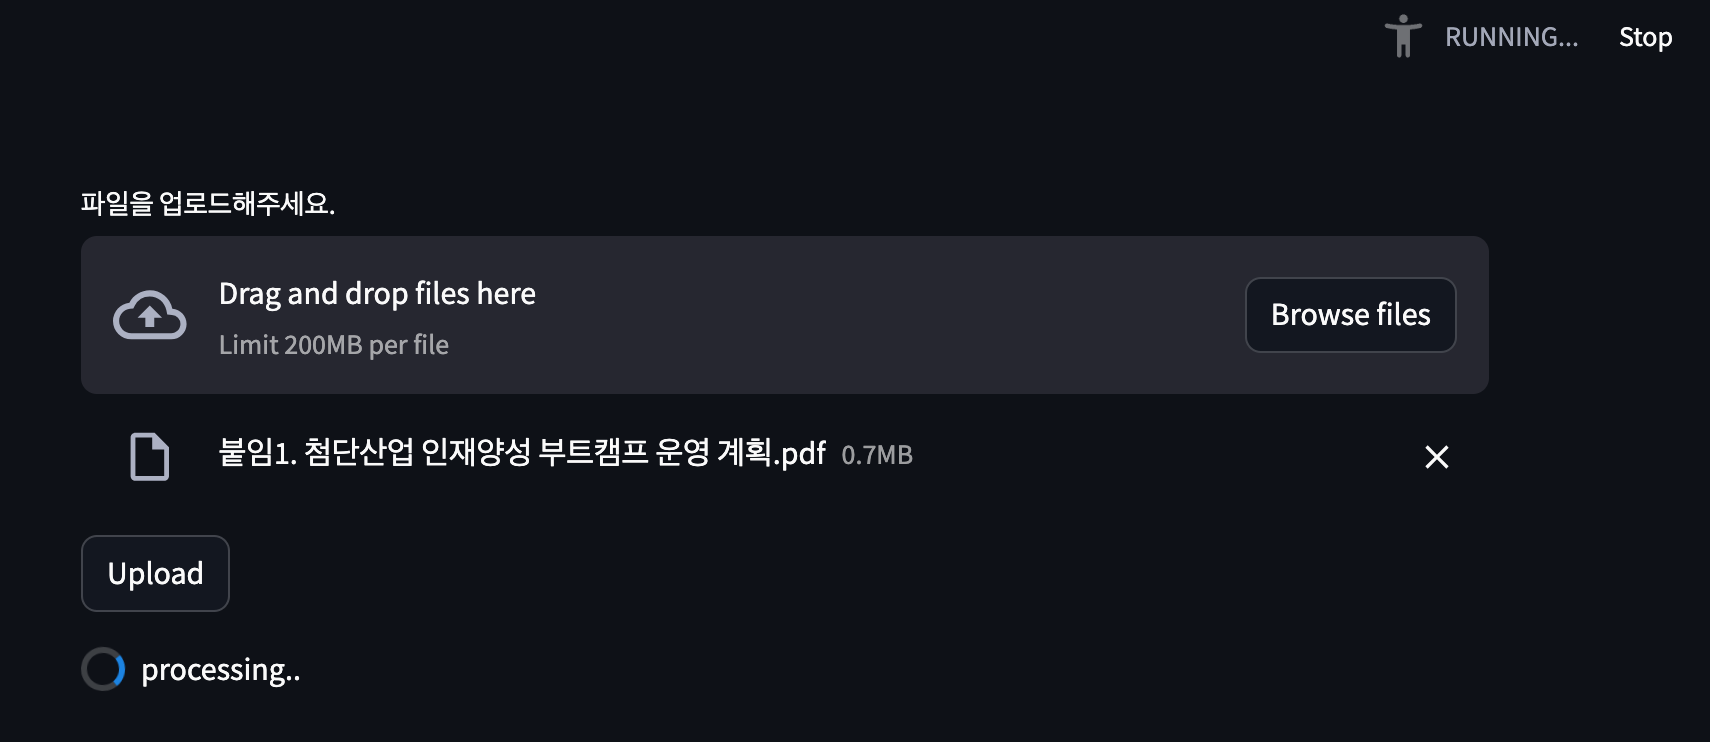

### 업로드되면 채팅창을 통해 질의응답할 준비 상태 완료
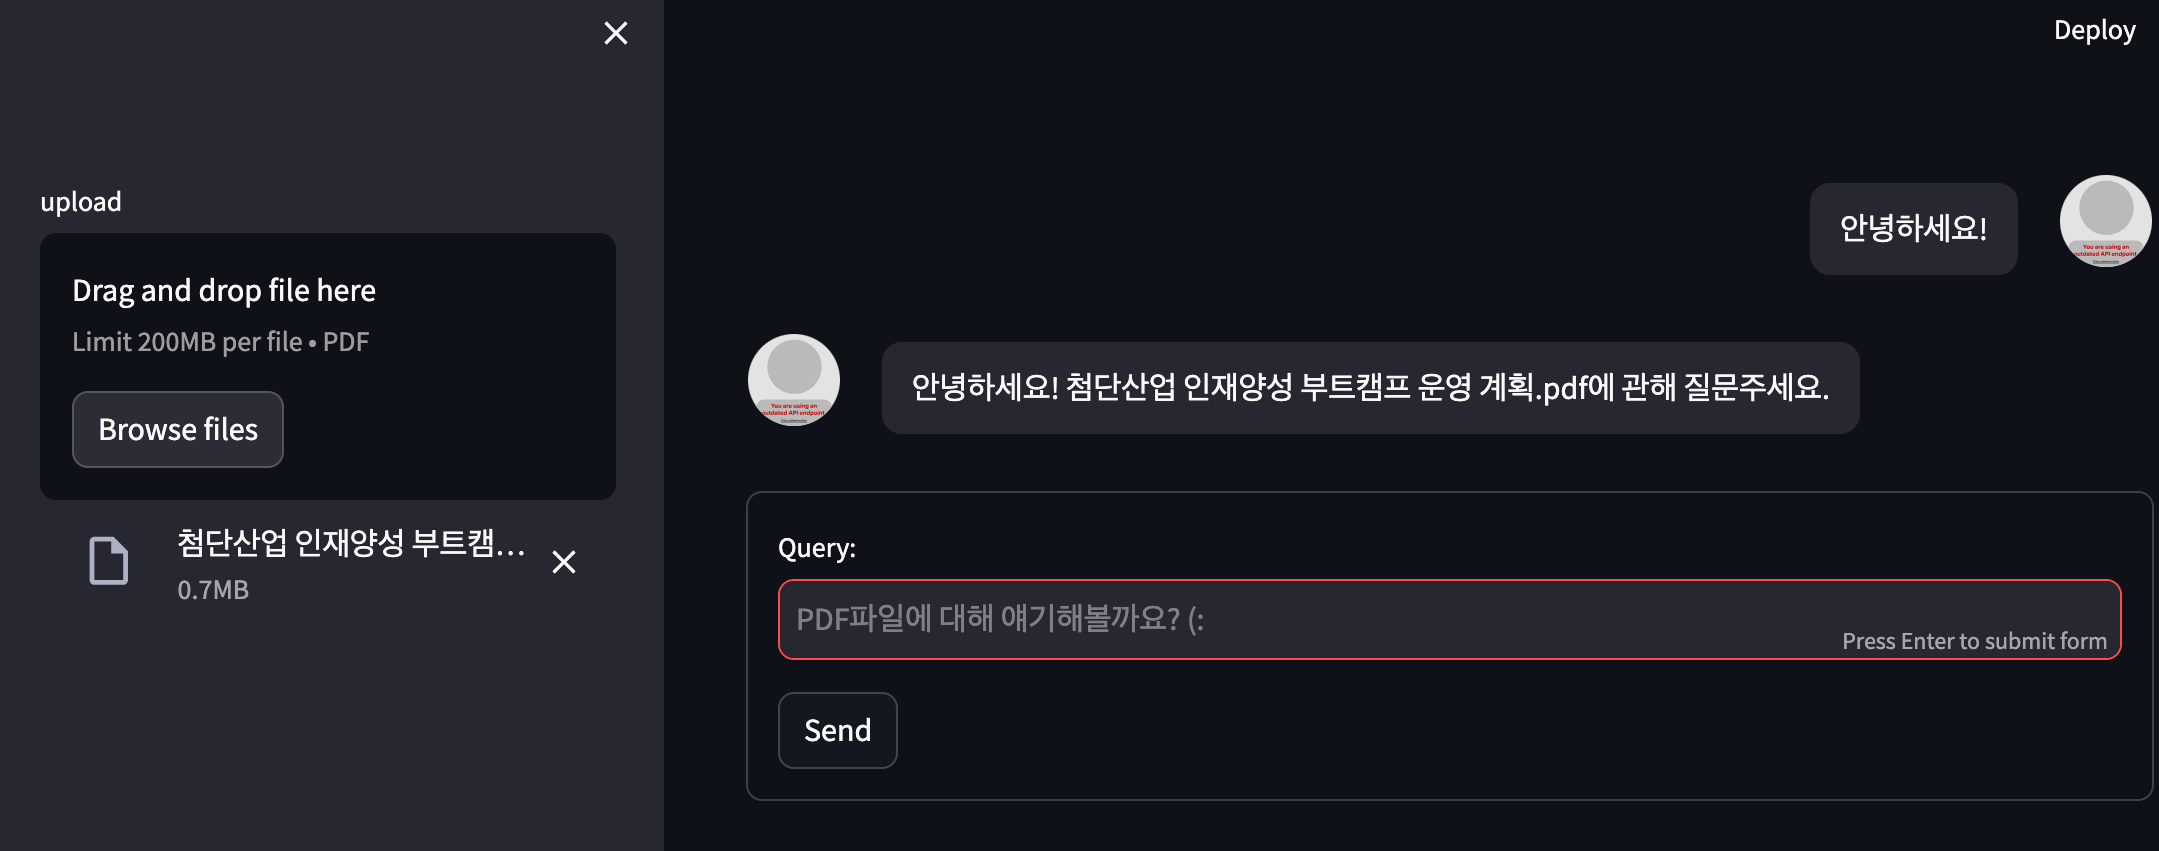

### PDF내용 기반으로 답변 생성
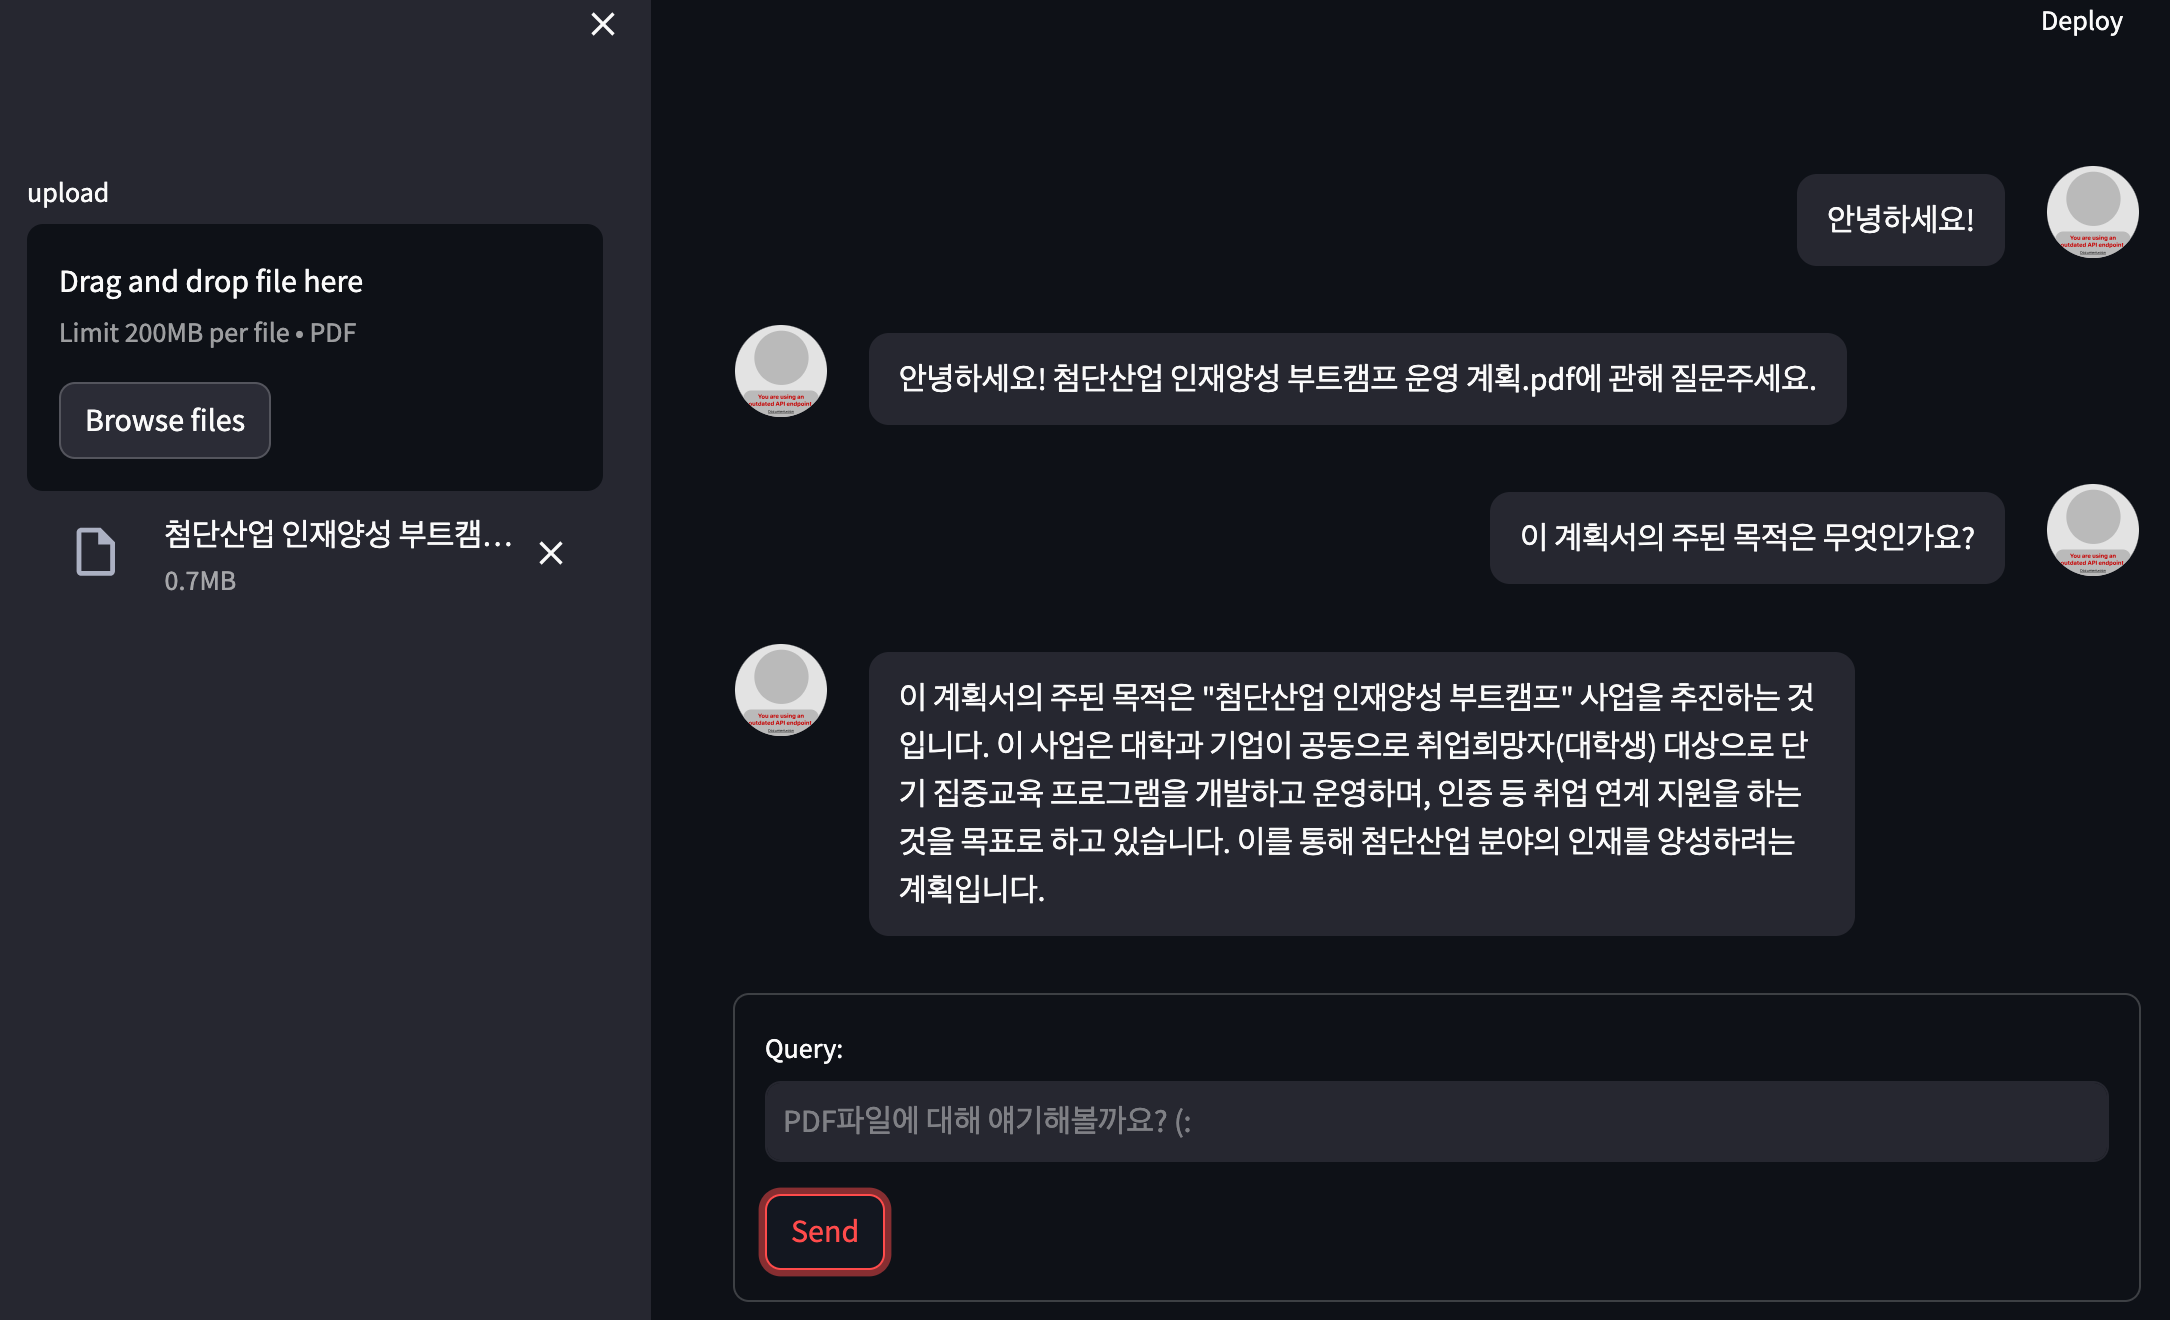